### Módulo 3 | PAIR PROGRAMMING | Regresión 5 | 31/05/22 | Almudena & Lara

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.multivariate.manova import MANOVA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve,roc_auc_score, classification_report
from sklearn.metrics import accuracy_score 


# EJERCICIO 1  

Buscar un conjunto de datos a analizar: (Obviar si se reutiliza el conjunto de las clases anteriores)
 - Se recomienda que el conjunto de datos a analizar tenga variables numéricas y categóricas, primando que haya más de una variable de tipo numérico. 
 Ya que tambien se utilizarán serán útiles a la hora de realizar predicciones en las clases de regresión lineal múltiple. 
 Así mismo se recomienda que los datasets esten ligeramente limpios para facilidar los análisis.

In [3]:
df = pd.read_csv('mdc.csv', index_col=0, encoding='latin-1')
df.head(2)

,title,year,genre,runtime,mpa_rating,imdb_rating,imdb_votes,imdb_gross,director,stars,description,crit_consensus,tomato_meter,tomato_review,tom_aud_score,tom_ratings,entity,id
1,Captain America,1944,"Action, Adventure, Sci-Fi",244,Approved,5.5,844,0,Elmer Clifton,"Elmer Clifton,Dick Purcell,Lorna Gray,Lionel A...",Superhero Captain America battles the evil for...,"Find one of these old serials, friend. They're...",0,1,82,250,MARVEL,1
2,Howard the Duck,1986,"Action, Adventure, Comedy",110,PG,4.7,44073,16300000,Willard Huyck,"Willard Huyck,Lea Thompson,Jeffrey Jones,Tim R...",A sarcastic humanoid duck is pulled from his h...,"While it has its moments, Howard the Duck suff...",13,78,38,50000,MARVEL,2


In [4]:
var = df["entity"].values.reshape(-1, 1)

enc = OneHotEncoder()
trans = enc.fit_transform(var)
df[["Marvel", "DC"]] = pd.DataFrame(trans.toarray())
df.head(2)

,title,year,genre,runtime,mpa_rating,imdb_rating,imdb_votes,imdb_gross,director,stars,description,crit_consensus,tomato_meter,tomato_review,tom_aud_score,tom_ratings,entity,id,Marvel,DC
1,Captain America,1944,"Action, Adventure, Sci-Fi",244,Approved,5.5,844,0,Elmer Clifton,"Elmer Clifton,Dick Purcell,Lorna Gray,Lionel A...",Superhero Captain America battles the evil for...,"Find one of these old serials, friend. They're...",0,1,82,250,MARVEL,1,0.0,1.0
2,Howard the Duck,1986,"Action, Adventure, Comedy",110,PG,4.7,44073,16300000,Willard Huyck,"Willard Huyck,Lea Thompson,Jeffrey Jones,Tim R...",A sarcastic humanoid duck is pulled from his h...,"While it has its moments, Howard the Duck suff...",13,78,38,50000,MARVEL,2,0.0,1.0


# EJERCICIO 2

Explicar los datos y las variables disponibles en el conjunto de datos seleccionado: (Obviar si se reutiliza el conjunto de las clases anteriores)
 - Esto se hace para que comprendais mejor los datos con los que estais trabajando.
 - Realizar un EDA sencillo para la variable dependiente y la variable independiente.

    - Lo obviamos porque está hecho en pairs anteriores.

# EJERCICIO 3

Realiza el ajuste logístico utilizando diversas métricas y realiza una gráfica mostrando los resultados.

- <font color = orange> Para este ejercicio cogemos la columna "Marvel" pues está codificada on 0 y 1, donde 0 es que la película NO es de Marvel y 1 que sí.
- Aunque, posiblemente, predecir - en función de diferentes variables (duración, votos, etc.) si una película es o no de una productora no parece muy útil, nos parece curioso ver si las predicciones coindicen con la realidad o si existe algún patrón para esas pelis que pueda diferenciarlas de las de DC.

<font color = orange> Hacemos un dataset con las variables numéricas (pues no todos nuestros datos están codificados) para realizar el modelo de regresión. 

In [9]:
df_numericas = df.select_dtypes(include=np.number)

<font color = orange> Como observamos antes que en las columnas Marvel y DC aparecen sendos registros nulos que afectan a la fórmula de la regresión, aplicamos un .dropna()

In [10]:
df_numericas = df_numericas.dropna()

- <font color = orange > Seleccionamos nuestra variable respuesta que, como decíamos, es binaria, y el resto serán variables independientes o - con suerte - explicativas. 
- Como pensamos que algunas variables son colineales, probamos diferentes VIF antes de aplicar el modelo:

In [11]:
def get_VIF(dataframe, target):
        X = add_constant(dataframe.loc[:, dataframe.columns != target])
        seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])] , index=X.columns,).sort_values(ascending= False)
        return seriesObject

In [12]:
get_VIF(df_numericas, "Marvel")

const            98609.008544
id                  14.126568
imdb_rating         14.031799
DC                  13.915996
tomato_review        9.345506
tom_aud_score        7.480127
year                 5.068313
tomato_meter         3.932753
imdb_gross           3.880648
imdb_votes           3.482336
tom_ratings          2.051415
runtime              1.620347
dtype: float64

- <font color = orange> Probamos diferentes columnas y combinaciones (las reflejamos con prints para no ocupar demasiadas celdas), y escogemos la última (en celda propia):

In [19]:
print(get_VIF(df_numericas.drop(columns = "id"), "Marvel"))
print(get_VIF(df_numericas.drop(columns = "imdb_rating"), "Marvel"))
print(get_VIF(df_numericas.drop(columns = "DC"), "Marvel"))
print(get_VIF(df_numericas.drop(columns = ["id", "DC"]), "Marvel"))
print(get_VIF(df_numericas.drop(columns = ["imdb_rating", "DC"]), "Marvel"))

const            92779.303659
imdb_rating         14.011036
tomato_review        8.248489
tom_aud_score        7.443544
year                 4.688239
tomato_meter         3.929801
imdb_gross           3.814546
imdb_votes           3.460805
tom_ratings          1.651883
runtime              1.620232
DC                   1.257359
dtype: float64
const            97459.662742
id                  14.105665
DC                  13.914980
tomato_review        8.982583
year                 5.037661
imdb_gross           3.880152
tom_aud_score        3.410071
imdb_votes           3.091316
tomato_meter         3.033135
tom_ratings          1.959139
runtime              1.618121
dtype: float64
const            90568.855104
imdb_rating         14.030774
tomato_review        8.415427
tom_aud_score        7.422075
year                 4.568148
tomato_meter         3.919822
imdb_gross           3.769430
imdb_votes           3.401855
tom_ratings          1.768898
runtime              1.620345
id        

In [20]:
get_VIF(df_numericas.drop(columns = ["imdb_rating", "DC", "tomato_review"]), "Marvel")

const            29610.232784
tom_aud_score        3.068287
imdb_gross           3.027042
tomato_meter         3.014018
imdb_votes           3.006623
runtime              1.498045
year                 1.480776
tom_ratings          1.465911
id                   1.242367
dtype: float64

<font color = orange > Ahora, habiendo reducido la colinealidad de nuestras variables al dejar de lado las columnas: imdb_rating, tomato_review y DC, hacemos los grupos de entrenamiento y test para nuestras variables predictoras y la variable respuesta:

In [21]:
x = df_numericas.drop(['Marvel', "DC", "imdb_rating"], axis = 1)
y = df_numericas['Marvel']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(71, 9) (71,)
(18, 9) (18,)


<font color = orange > Realizamos la regresión logística:

In [22]:
# Definimos la regresión logistica
log_reg = LogisticRegression(n_jobs=-1, max_iter = 1000)

# ajustamos el modelo
log_reg.fit(x_train,y_train)

# obtenemos las predicciones para el conjunto de entrenamiento
y_pred_train = log_reg.predict(x_train)

# obtenemos las predicciones para el conjunto de test
y_pred_test = log_reg.predict(x_test)

train_score_lr = accuracy_score(y_train, y_pred_train)
print('Para el conjunto train:---------------')
print('El valor de accuracy es ',train_score_lr)

print('Para el conjunto test:---------------')
test_score_lr = accuracy_score(y_test, y_pred_test)
print('El valor de accuracy es ',test_score_lr)

Para el conjunto train:---------------
El valor de accuracy es  0.6619718309859155
Para el conjunto test:---------------
El valor de accuracy es  0.6666666666666666


<font color = orange> Y visualizamos la matriz de confusión, donde observamos que solo un 12 % de los datos predichos han sido correctos. Por lo que entendemos que nuestro modelo de regresión podría ser mejorado o, más concretamente, dado el tema que estamos estudiando, que las variables independientes no son explicativas para la variable respuesta. 

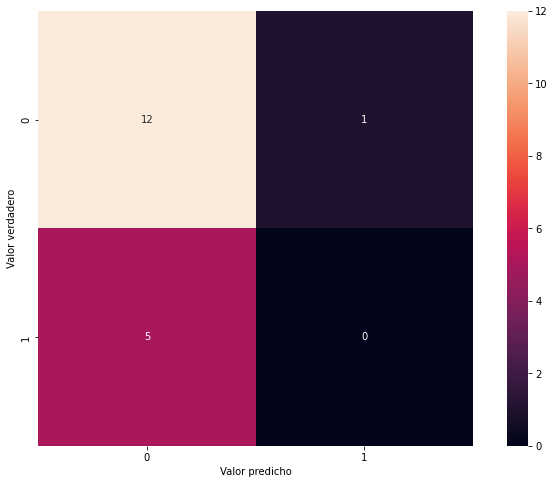

In [25]:
mat_lr = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize = (12, 8))
sns.heatmap(mat_lr, square=True, annot=True, fmt="d")

plt.xlabel('Valor predicho')
plt.ylabel("Valor verdadero")
plt.show()

<font color = orange> 
Incluimos diferentes métricas que nos gustaría comentar en la evaluación.

In [27]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.71      0.92      0.80        13
         1.0       0.00      0.00      0.00         5

    accuracy                           0.67        18
   macro avg       0.35      0.46      0.40        18
weighted avg       0.51      0.67      0.58        18



The score AUC is: 0.46153846153846156


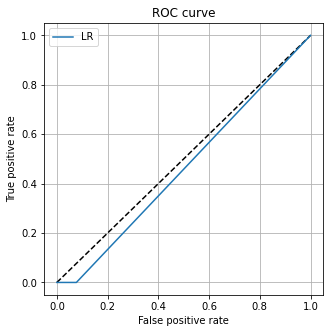

In [28]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_test)
auc_LR=roc_auc_score(y_test, y_pred_test)
print('The score AUC is:',auc_LR)

plt.figure(figsize=(5,5))

plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_log, tpr_log, label='LR')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid()
plt.show()